7 countries

6 page long policy briefs


USA
UK

EU (28)

India
France

1.1
USA
India
France

1.2
UK
USA (Hawaii? Alaska? -> check with country author)
EU(28) (Exclude oversees)
India
France

1.3
India


Excel spreadsheet

Columns -> countries
Rows -> years

Generate plots anyways

Generate maps


In [1]:
%matplotlib inline

from pathlib import Path
from datetime import date

import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd


import affine
# import fiona

# from scipy import stats
from tqdm import tnrange, tqdm_notebook, tqdm

import population_tools

from config import (DATA_SRC, POP_DATA_SRC)

In [2]:
from joblib import Parallel, delayed

In [20]:
power_level_data = {
    200: (35.53,  3.94),
    300: (33.49, 3.94),
    400: (32.47, 4.16)
    }


MAX_YEAR = 2017
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2008

RESULTS_FOLDER = Path('./results/lancet2018/countries/1.3 labour')

COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/countries_rasters/*.nc'

# LIMIT to the following countries for now
# SELECTED_COUNTRIES = ['IND', 'USA', 'GBR', 'FRA', 'SWE', 'AUS']
SELECTED_COUNTRIES = ['AUS']

## Load country data

In [17]:
# Load a country shapefile for rasterising
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))
# Translate to match raster coordinates
COUNTRIES.geometry = COUNTRIES.translate(xoff=180)

# Remove missing UN A3 code fields, convert to int and set as index
COUNTRIES.loc[COUNTRIES.un_a3 == '-099', 'un_a3'] = np.nan
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(float)
COUNTRIES = COUNTRIES[np.isfinite(COUNTRIES.un_a3)]
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(int)
COUNTRIES = COUNTRIES.set_index('un_a3')

In [29]:
COUNTRY_RASTER = xr.open_mfdataset(str(COUNTRY_RASTER_FILES))

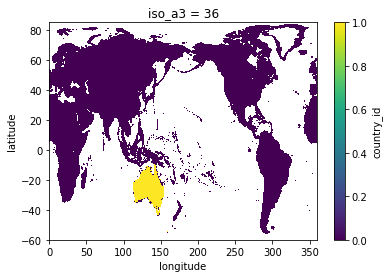

In [30]:
COUNTRY_RASTER.sel(iso_a3=36).country_id.plot()

In [21]:
COUNTRIES[COUNTRIES.adm0_a3.isin(SELECTED_COUNTRIES)]

,scalerank,featurecla,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,...,continent,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,geometry
un_a3,,,,,,,,,,,,,,,,,,,,,
36,1,Admin-0 country,2.0,Australia,AU1,1.0,2.0,Country,Australia,AUS,...,Oceania,Oceania,Australia and New Zealand,East Asia & Pacific,9.0,9.0,4.0,-99.0,1.0,"(POLYGON ((338.87880859375 -54.709765625, 338...."


## 1.3 Labor capacity change

In [31]:
hours_lost_200 = xr.open_mfdataset(str(DATA_SRC / 'lancet' / f'monthly_labour_loss_hours_200' / 'loss_hours_*.nc'))
hours_lost_300 = xr.open_mfdataset(str(DATA_SRC / 'lancet' / f'monthly_labour_loss_hours_300' / 'loss_hours_*.nc'))
hours_lost_400 = xr.open_mfdataset(str(DATA_SRC / 'lancet' / f'monthly_labour_loss_hours_400' / 'loss_hours_*.nc'))

# Calculate the yearly total hours lost for each power level
hours_lost_200 = hours_lost_200.resample(time='1Y').sum()
hours_lost_200 = hours_lost_200.rename({'time': 'year'})
hours_lost_200['year'] = hours_lost_200['year.year']

hours_lost_300 = hours_lost_300.resample(time='1Y').sum()
hours_lost_300 = hours_lost_300.rename({'time': 'year'})
hours_lost_300['year'] = hours_lost_300['year.year']

hours_lost_400 = hours_lost_400.resample(time='1Y').sum()
hours_lost_400 = hours_lost_400.rename({'time': 'year'})
hours_lost_400['year'] = hours_lost_400['year.year']


pct_working_age = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'yearly_pct_working_age' / 'pct_working_age_*.nc'))

yearly_pct_in_agri = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'yearly_pct_in_agri' / 'pct_in_sector_*.nc'))

yearly_pct_in_indu = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'yearly_pct_in_indu' / 'pct_in_sector_*.nc'))

yearly_pct_in_serv = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'yearly_pct_in_serv' / 'pct_in_sector_*.nc'))

agri_weights = pct_working_age.pct_working_age * yearly_pct_in_agri.pct_in_sector
indu_weights = pct_working_age.pct_working_age * yearly_pct_in_indu.pct_in_sector
serv_weights = pct_working_age.pct_working_age * yearly_pct_in_serv.pct_in_sector

In [33]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:61716 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


In [36]:
# Map population in agriculture to 400W loss hours
agri = population_tools.project_to_population(hours_lost_400.loss_hours, 
                                                 agri_weights, end_year=MAX_YEAR, 
                                              get_ts=False)

# Map population in industry to 300W loss hours
indu = population_tools.project_to_population(hours_lost_300.loss_hours, 
                                              indu_weights, end_year=MAX_YEAR, 
                                              get_ts=False)

# Map population in service to 200W loss hours
serv = population_tools.project_to_population(hours_lost_200.loss_hours, 
                                              serv_weights, end_year=MAX_YEAR, 
                                              get_ts=False)

In [37]:
total = agri + indu + serv

In [51]:
tmp = COUNTRIES[COUNTRIES.adm0_a3.isin(SELECTED_COUNTRIES)]

for iso_as, row in tmp.iterrows():
    country_mask = COUNTRY_RASTER.sel(iso_a3=iso_as).country_id
    c_total = agri * country_mask
    agri_ts = (c_total.drop('iso_a3')
                      .sum(dim=['latitude', 'longitude'],skipna=True)
                      .compute()
                      .to_dataframe('Agriculture'))
    c_total = indu * country_mask
    indu_ts = (c_total.drop('iso_a3')
                      .sum(dim=['latitude', 'longitude'],skipna=True)
                      .compute()
                      .to_dataframe('Industry'))
    
    c_total = serv * country_mask
    serv_ts = (c_total.drop('iso_a3')
                      .sum(dim=['latitude', 'longitude'],skipna=True)
                      .compute()
                      .to_dataframe('Service'))
    
    total_loss_sectors = pd.concat([agri_ts, indu_ts, serv_ts], axis=1)
    total_loss_sectors['Total'] = total_loss_sectors.sum(axis=1)

#     c_total = total * country_mask
#     ttl_ts = (c_total.drop('iso_a3')
#                       .sum(dim=['latitude', 'longitude'],skipna=True)
#                       .compute()
#                       .to_dataframe('Total'))
    
    total_loss_sectors.to_excel(RESULTS_FOLDER / f'{row.adm0_a3}_loss_hours.xlsx')

In [56]:
agri_ts = agri_ts.rename(columns={'Total': 'Agriculture'})
indu_ts = indu_ts.rename(columns={'Total': 'Industry'})
serv_ts = serv_ts.rename(columns={'Total': 'Service'})

In [58]:
total_loss_sectors = pd.concat([agri_ts, indu_ts, serv_ts], axis=1)
total_loss_sectors['Total'] = total_loss_sectors.sum(axis=1)

In [60]:
total_loss_sectors.to_excel(RESULTS_FOLDER / f'{row.adm0_a3}_loss_hours.xlsx')

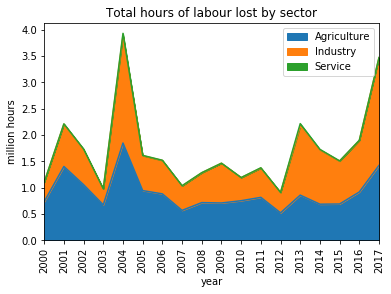

In [62]:
t = total_loss_sectors / 1_000_000
ax = t[['Agriculture', 'Industry', 'Service']].plot.area()
ax.set_ylabel('million hours')

plt.title('Total hours of labour lost by sector')
plt.xlim(2000, 2017)
plt.xticks(t.index, rotation=90);
plt.savefig(RESULTS_FOLDER / f'{row.adm0_a3}_total_labour_loss_by_sector_area.png', bbox_inches='tight', dpi=300)



### Labour capacity by country

In [14]:
countries_raster_anom = rasterize_countries(countries, labour_delta)

In [15]:
results = [do_selection(row, labour_delta, countries_raster_anom) 
           for idx, row in tqdm_notebook(countries.iterrows(), total=len(countries)) if row.iso_a2]

anom_by_country = pd.concat(results, axis=1)

### Exposures by country




In [28]:
def do_exposure(row, data, country_da, norm=True):
    country_num = row.index_number
    exposures_ts = _project_to_population(data, country_da, country_num, norm=norm)
    exposures_ts.name = row.iso_a2
    exposures_ts = exposures_ts.to_dataframe()
    return exposures_ts


In [17]:
with population_tools.PopulationProjector('population_count_2000-2020.nc') as pop:
    countries_raster_expo = pop.rasterize_data(countries, 'index_number', 
                                               affine=affine.Affine.translation(-180, 0) * pop.affine)

In [30]:
country_da = countries_raster_expo.copy()
country_num = 99
country_da.shape = (*country_da.shape, 1)
with population_tools.PopulationProjector('population_count_2000-2020.nc') as pop:
    pop_sel = (pop.data * pct_rural_rasters).where(country_da == country_num).compute()
    pop_sum = pop_sel.sum(dim=['latitude', 'longitude'], skipna=True)

In [14]:
select_country = ['IN']

In [ ]:
# do_exposure(row, labour_capacity, countries_raster_expo, norm=True) 

In [31]:
labour_change_exposure_ts = _project_to_population(labour_delta, country_da, country_num, norm=True)

In [32]:
labour_change_exposure_ts.to_dataframe(
    name='labour_capacity_change').to_csv(COUNTRY_BRIEFS / 'labour_capacity'
                                        / 'IN_labour_capacity_change.csv')

In [34]:
global_capacity_ts = xr.open_dataarray(str(DATA_SRC/'lancet'/'labour_capacity.nc'))

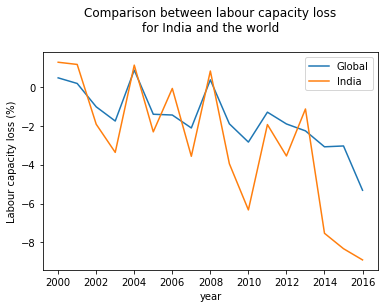

In [37]:
# labour_capacity_loss_ts.plot(label='Global')
global_capacity_ts.plot(color='C0',label='Global')
labour_change_exposure_ts.plot(color='C1', label='India')
plt.title('''Comparison between labour capacity loss
for India and the world
''')
plt.ylabel('Labour capacity loss (%)')
plt.legend()
plt.savefig(str(COUNTRY_BRIEFS / 'labour_capacity' / 'IN_labour_capacity.png'), bbox_inches='tight')

In [ ]:
results = [do_exposure(row, labour_capacity, countries_raster_expo, norm=True) 
           for idx, row in tqdm(countries.iterrows(), total=len(countries)) if row.iso_a2 in select_country]

capacity_by_country = pd.concat(results, axis=1)

  0%|          | 0/241 [00:00<?, ?it/s]

In [ ]:
results = [do_exposure(row, labour_delta, countries_raster_expo, norm=True) 
           for idx, row in tqdm(countries.iterrows(), total=len(countries)) if row.iso_a2 in select_country]

delta_by_country = pd.concat(results, axis=1)

In [37]:
capacity_by_country.to_csv(COUNTRY_BRIEFS / 'india'/ 'labour_capacity.csv')

In [48]:
capacity_by_country = pd.read_csv(COUNTRY_BRIEFS / 'india'/ 'labour_capacity.csv', index_col='year')

In [21]:
from cartopy.io import shapereader

In [22]:
import cartopy

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


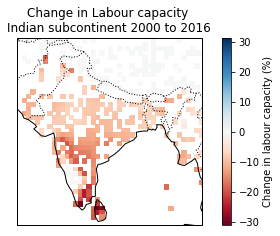

In [24]:
year_data = labour_delta.sel(year=2016) - labour_delta.sel(year=2000)
year_data = year_data * population_tools.get_water_mask(year_data)
f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.PlateCarree())
year_data.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs=dict(label='Change in labour capacity (%)'),
                          cmap='RdBu'
                         )
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

ax.set_extent((66.18,98.3,5.32, 36.91))
ax.coastlines()
plt.tight_layout()
plt.title('''Change in Labour capacity 
Indian subcontinent 2000 to 2016''')


f.savefig(COUNTRY_BRIEFS / 'india'/ 'labour_capacity_delta_change_2000-2016.png', dpi=300, bbox_inches='tight')
# f.savefig('labour_capacity_delta_change_2000-2016.pdf')

## Calculate lost labour in terms of equivalent number of people removed

In [18]:
def get_lost_population(labour_capacity):

    with population_tools.PopulationProjector() as pop:
        rural_pop_sum = (pop.data * pct_rural_rasters).sum(dim=['latitude', 'longitude'])
            
        def _gen():
            for year in tnrange(2000,2017):
                yield pop.project(year, (100 - labour_capacity.sel(year=year))) * pct_rural_rasters.sel(year=year)
                
        global_capacity = xr.concat(_gen(), dim='year')

        global_capacity_ts = global_capacity.sum(dim=['latitude', 'longitude'])
        global_capacity_ts.name = 'lost_capacity'
    return global_capacity_ts.compute() / 100

# lost_capacity_ts = get_lost_population(labour_delta)

In [24]:
labour_delta_frac = (labour_delta / 100).copy()

In [37]:
select_country_a3 = ['IND']

In [39]:
def _project_to_population(anom_data, country_da, country_num):
    """Wrap in function to control memory use"""
    country_da = country_da.copy()
    country_da.shape = (*country_da.shape, 1)
    
    with population_tools.PopulationProjector('population_count_2000-2020.nc') as pop:
        pop_sel = (pop.data * pct_rural_rasters).where(country_da == country_num).compute()
        pop_sum = pop_sel.sum(dim=['latitude', 'longitude'], skipna=True)


        def _gen():
            for year in tnrange(2000,2017):
                        
                                 
                proj = pop.project_param(anom_data.sel(year=year))
                
                proj = proj * pop_sel.sel(year=year)

                proj.compute()
                yield proj
                
        exposures = xr.concat(_gen(), dim='year')   
        exposures_ts = (exposures ).sum(dim=['latitude', 'longitude'], 
                                                 skipna=True).compute()
        return exposures_ts


def calc_num_lost(row, data, country_da):
    country_num = row.index_number
    exposures_ts = _project_to_population(data, country_da, country_num)
    exposures_ts.name = row.iso_a2
    exposures_ts = exposures_ts.to_dataframe()
    return exposures_ts




In [40]:
results = [calc_num_lost(row, labour_delta_frac, countries_raster_expo) 
           for idx, row in tqdm_notebook(countries.iterrows(), total=len(countries)) if row.iso_a3 in select_country_a3]

In [48]:
labour_persons_change = pd.concat(results)

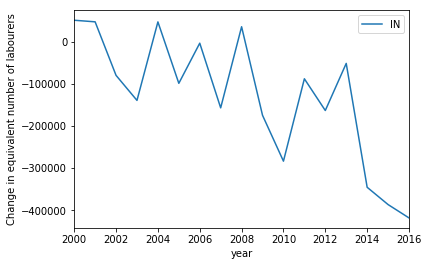

In [52]:

labour_persons_change.plot()
plt.ylabel('''Change in equivalent number of labourers''')
plt.savefig(str(COUNTRY_BRIEFS / 'labour_capacity' /'IN_labourer_number_change.png'), bbox_inches='tight')

In [50]:
labour_persons_change.to_csv(COUNTRY_BRIEFS / 'labour_capacity' /'IN_labourer_number_change.csv')